# Quora Question Pair Similarity

## Problem Statement

- **Objective:** Identify which questions on Quora are duplicates of questions that have already been asked.
- **Purpose:** This analysis can be valuable for instantly providing answers to questions that have already been answered.
- **Task:** Predict whether a given pair of questions are duplicates of each other.
er.


## 1)Importing Libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import plotly.offline as py
from sklearn.model_selection import GridSearchCV
from prettytable import PrettyTable

from wordcloud import WordCloud
import plotly.graph_objs as go
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from tqdm import tqdm
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix
from xgboost import XGBClassifier
import distance

from thefuzz import fuzz
from thefuzz import process

## 2)Reading Data & Exploratory Data Analysis


In [35]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])

Number of data points: 404290


In [36]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


**We are given the following data fields:**

- `id`
- `qid` (1, 2): Identifiers for the questions.
- `question` (1, 2): The text of the questions.
- `is_duplicate`: 
  - `1` -> Indicates that Q1 and Q2 are duplicates.
  - `0` -> Indicates that Q1 and Q2 are not duplicates.
ther.

**Number of non-duplicate(non smilar) and duplicate(similar) questions:**

Axes(0.125,0.11;0.775x0.77)


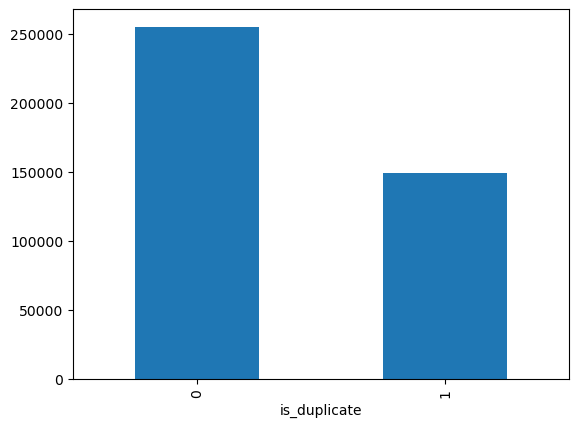

In [38]:
print(df.groupby("is_duplicate")['id'].count().plot.bar())

In [39]:
df['is_duplicate'].value_counts()

is_duplicate
0    255027
1    149263
Name: count, dtype: int64

In [40]:
print("Different Question pairs: {} % ".format(100 - round(df['is_duplicate'].mean()*100, 2)))
print("Similar Question pairs: {} % ".format(round(df['is_duplicate'].mean()*100, 2)))

Different Question pairs: 63.08 % 
Similar Question pairs: 36.92 % 


In [41]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
repeated_qs = np.sum(qids.value_counts() > 1)
max_repeats = max(qids.value_counts())

print("Total number of unique questions:", unique_qs)
print(f'Number of unique questions that appear more than once: {repeated_qs} ({repeated_qs / unique_qs * 100:.2f}%)')
print(f'Max number of times a single question is repeated: {max_repeats}')

Total number of unique questions: 537933
Number of unique questions that appear more than once: 111780 (20.78%)
Max number of times a single question is repeated: 157


In [42]:
#checking whether there are any repeated pair of questions

df.duplicated().any()

False

**Number of occurrences of each question**


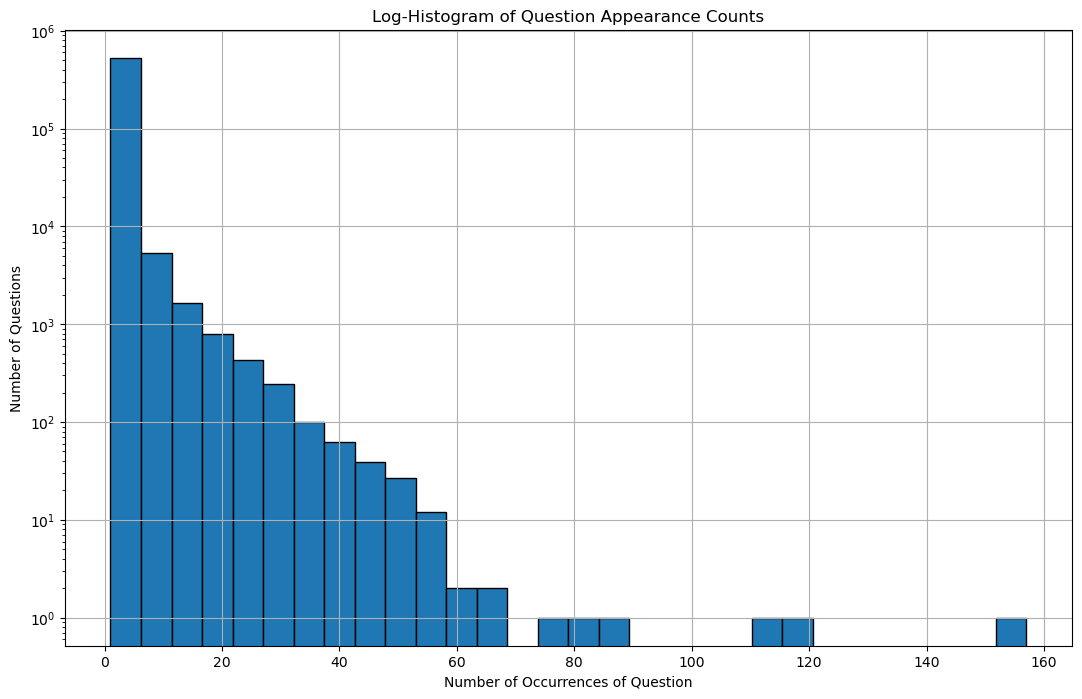

In [43]:
# Plotting
plt.figure(figsize=(13, 8))
plt.hist(qids.value_counts(), bins=30, edgecolor='black') 
plt.yscale('log', nonpositive='clip')
plt.title('Log-Histogram of Question Appearance Counts')
plt.xlabel('Number of Occurrences of Question')
plt.ylabel('Number of Questions')
plt.grid(True)
plt.show()

In [44]:
# checking for null values
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [45]:
df = df.fillna('')
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

## 3)Feature Engineering

**Constructing new features**:

- **freq_qid1** = Frequency of qid1's
- **freq_qid2** = Frequency of qid2's
- **q1len** = Length of Question 1
- **q2len** = Length of Question 2
- **q1_n_words** = Number of words in Question 1
- **q2_n_words** = Number of words in Question 2
- **word_Common** = Number of common unique words in Question 1 and Question 2
- **word_Total** = Total number of words in Question 1 + Total number of words in Question 2
- **word_share** = (word_Common) / (word_Total)
- **freq_q1 + freq_q2** = Sum total of frequency of qid1 and qid2
- **freq_q1 - freq_q2** = Absolute difference of frequency of qid1 and qid2

In [46]:
df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count')
df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
df['q1len'] = df['question1'].str.len()
df['q2len'] = df['question2'].str.len()
df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

def common_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * len(w1 & w2)

df['word_Common'] = df.apply(common_words, axis=1)

def total_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * (len(w1) + len(w2))

df['word_Total'] = df.apply(total_words, axis=1)

def shared_words(row):
  w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
  w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))
  return 1.0 * len(w1 & w2) / (len(w1) + len(w2))

df['word_share'] = df.apply(shared_words, axis= 1)

df['freq_q1+q2'] = df['freq_qid1'] + df['freq_qid2']
df['freq_q1-q2'] = df['freq_qid1'] - df['freq_qid2']

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [47]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))
print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))
print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


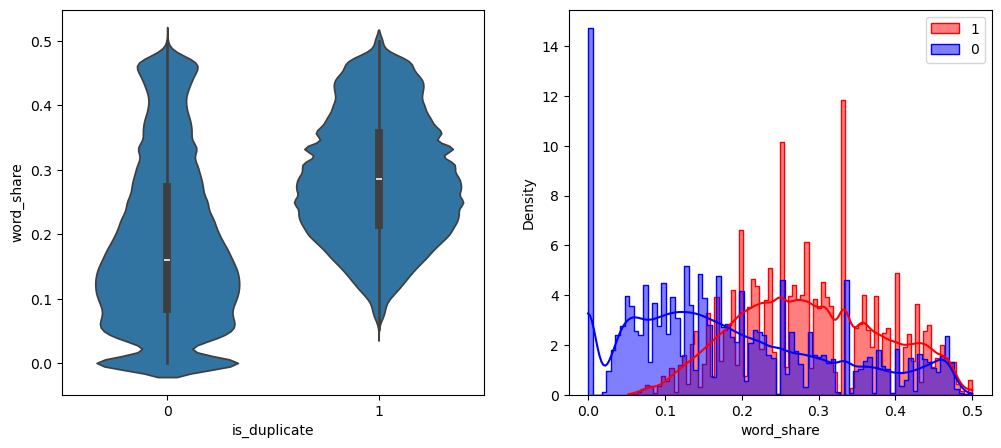

In [48]:
plt.figure(figsize=(12, 5))

# First subplot: Violin plot
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_share', data=df)

# Second subplot: Histograms and KDE plots
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_share'], kde=True, label="1", color='red', stat='density', element='step')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_share'], kde=True, label="0", color='blue', stat='density', element='step')
plt.legend()

plt.show()


- The distributions for word_share have some overlap on the middle and right-hand side, i.e., there are quite a lot of questions with high word similarity.

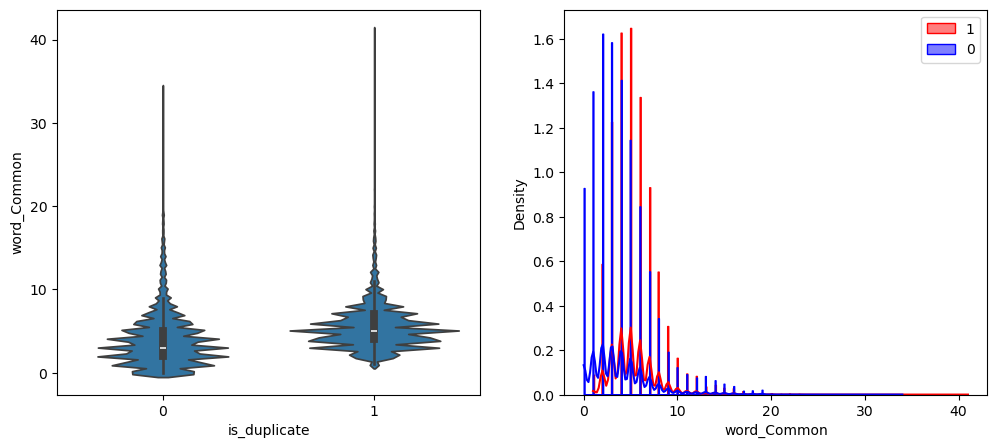

In [49]:
plt.figure(figsize=(12, 5))

# First subplot: Violin plot
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='word_Common', data=df)

# Second subplot: Histograms and KDE plots
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_duplicate'] == 1.0]['word_Common'], kde=True, label="1", color='red', stat='density', element='step')
sns.histplot(df[df['is_duplicate'] == 0.0]['word_Common'], kde=True, label="0", color='blue', stat='density', element='step')
plt.legend()

plt.show()

- The distributions of the word_Common feature in similar and non-similar questions are highly overlapping.

## 4)Text Preprocessing


- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [50]:
import nltk
nltk.download('stopwords')

STOP_WORDS = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
        .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
        .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
        .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
        .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
        .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
        .replace("€", " euro ").replace("'ll", " will")
    
    # Handling large numbers
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    # Remove HTML tags
    x = BeautifulSoup(x, "lxml").get_text()
    
    # Remove non-alphanumeric characters
    x = re.sub(r'\W', ' ', x)
    
    # Remove stopwords
    x = ' '.join([word for word in x.split() if word not in STOP_WORDS])
    
    # Stemming
    porter = PorterStemmer()
    x = ' '.join([porter.stem(word) for word in x.split()])
    
    return x

## 5)Advanced Feature Extraction (NLP and Fuzzy Features)



### Definition:
- **Token**: A token is obtained by splitting a sentence on spaces.
- **Stop Word**: Stop words as per NLTK.
- **Word**: A token that is not a stop word.

### Features:

- **cwc_min**:  
  Ratio of `common_word_count` to the minimum length of word count of Q1 and Q2.  
  Formula:  
  `cwc_min = common_word_count / min(len(q1_words), len(q2_words))`
  
- **cwc_max**:  
  Ratio of `common_word_count` to the maximum length of word count of Q1 and Q2.  
  Formula:  
  `cwc_max = common_word_count / max(len(q1_words), len(q2_words))`
  
- **csc_min**:  
  Ratio of `common_stop_count` to the minimum length of stop word count of Q1 and Q2.  
  Formula:  
  `csc_min = common_stop_count / min(len(q1_stops), len(q2_stops))`
  
- **csc_max**:  
  Ratio of `common_stop_count` to the maximum length of stop word count of Q1 and Q2.  
  Formula:  
  `csc_max = common_stop_count / max(len(q1_stops), len(q2_stops))`
  
- **ctc_min**:  
  Ratio of `common_token_count` to the minimum length of token count of Q1 and Q2.  
  Formula:  
  `ctc_min = common_token_count / min(len(q1_tokens), len(q2_tokens))`
  
- **ctc_max**:  
  Ratio of `common_token_count` to the maximum length of token count of Q1 and Q2.  
  Formula:  
  `ctc_max = common_token_count / max(len(q1_tokens), len(q2_tokens))`
  
- **last_word_eq**:  
  Check if the last word of both questions is equal or not.  
  Formula:  
  `last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])`
  
- **first_word_eq**:  
  Check if the first word of both questions is equal or not.  
  Formula:  
  `first_word_eq = int(q1_tokens[0] == q2_tokens[0])`
  
- **abs_len_diff**:  
  Absolute length difference between Q1 and Q2.  
  Formula:  
  `abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))`
  
- **mean_len**:  
  Average token length of both questions.  
  Formula:  
  `mean_len = (len(q1_tokens) + len(q2_tokens)) / 2`
  
- **fuzz_ratio**:  
  Fuzzy string matching score using `fuzz_ratio`.  
  References:  
  [Fuzzywuzzy GitHub](https://github.com/seatgeek/fuzzywuzzy#usage)  
  [Fuzzywuzzy Explanation](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
  
- **fuzz_partial_ratio**:  
  Partial fuzzy string matching score.  
  References:  
  [Fuzzywuzzy GitHub](https://github.com/seatgeek/fuzzywuzzy#usage)  
  [Fuzzywuzzy Explanation](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
  
- **token_sort_ratio**:  
  Token sort ratio for fuzzy string matching.  
  References:  
  [Fuzzywuzzy GitHub](https://github.com/seatgeek/fuzzywuzzy#usage)  
  [Fuzzywuzzy Explanation](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
  
- **token_set_ratio**:  
  Token set ratio for fuzzy string matching.  
  References:  
  [Fuzzywuzzy GitHub](https://github.com/seatgeek/fuzzywuzzy#usage)  
  [Fuzzywuzzy Explanation](http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/)
  
- **longest_substr_ratio**:  
  Ratio of the length of the longest common substring to the minimum length of token count of Q1 and Q2.  
  Formula:  
  `longest_substr_ratio = len(longest_common_substring) / min(len(q1_tokens), len(q2_tokens))`

In [52]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

In [53]:
# get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://github.com/seatgeek/thefuzz
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [54]:
df = extract_features(df)
df.head()

C:\Users\karti\AppData\Local\Temp\ipykernel_2772\3659970934.py:16: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,...,0.714276,0.0,1.0,1.0,6.5,100,92,92,100,0.971429
1,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,4,1,51,88,...,0.399996,0.0,0.0,5.0,7.5,89,62,62,94,0.812500
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,1,1,73,59,...,0.499992,0.0,0.0,1.0,5.5,85,74,56,64,0.290323
3,3,7,8,mental lone solv,find remaind math 23 24 math divid 24 23,0,1,1,50,65,...,0.000000,0.0,0.0,6.0,6.0,22,21,21,31,0.058824
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,3,1,76,39,...,0.199998,0.0,0.0,5.0,7.5,53,42,42,54,0.206897


In [56]:
df.to_csv("train_feat.csv", index=False)

## 6)Analysis of extracted features

**Plotting Word clouds**- Creating Word Cloud of Duplicates and Non-Duplicates Question pairss


In [57]:
df = pd.read_csv("train_feat.csv")

In [59]:
df_duplicate = df[df['is_duplicate'] == 1]
df_nonduplicate = df[df['is_duplicate'] == 0]

# converting 2d array of q1 and q2 into 1d
textp = np.dstack((df_duplicate['question1'], df_duplicate['question2'])).flatten()
textn = np.dstack((df_nonduplicate['question1'], df_nonduplicate['question2'])).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(textp))
print ("Number of data points in class 0 (non duplicate pairs) :",len(textn))

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [60]:
textp_w = " ".join(str(words) for words in textp)
textn_w = " ".join(str(words) for words in textn)

print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 8860531
Total number of words in non duplicate pair questions : 18582078


Word Cloud for Duplicate Question pairs


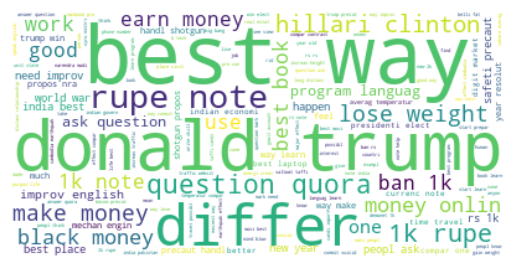

In [61]:
wc = WordCloud(background_color="white", max_words=len(textp_w))
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

Word Cloud for non-Duplicate Question pairs:


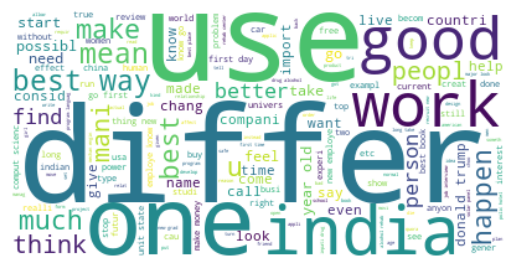

In [62]:
wc = WordCloud(background_color= "white", max_words= len(textn_w))
wc.generate(textn_w)
print("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation= 'bilinear')
plt.axis("off")
plt.show()
     

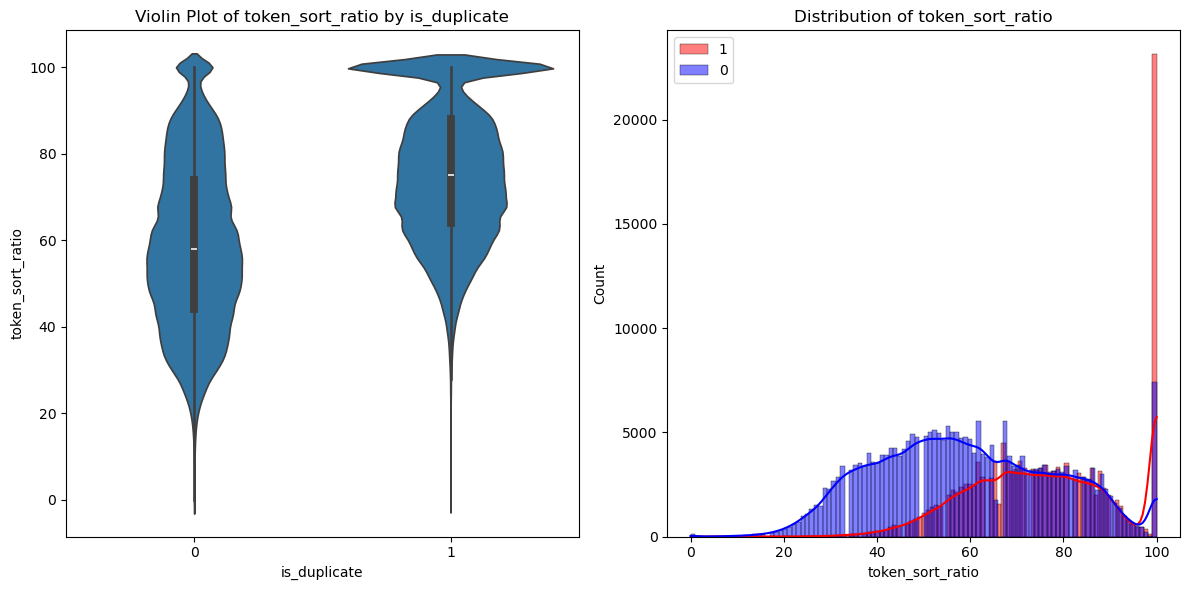

In [63]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(12, 6))

# Subplot 1: Violin plot
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='token_sort_ratio', data=df)
plt.title('Violin Plot of token_sort_ratio by is_duplicate')

# Subplot 2: Histograms
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'], label="1", color='red', kde=True)
sns.histplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'], label="0", color='blue', kde=True)
plt.title('Distribution of token_sort_ratio')
plt.legend()

plt.tight_layout()
plt.show()


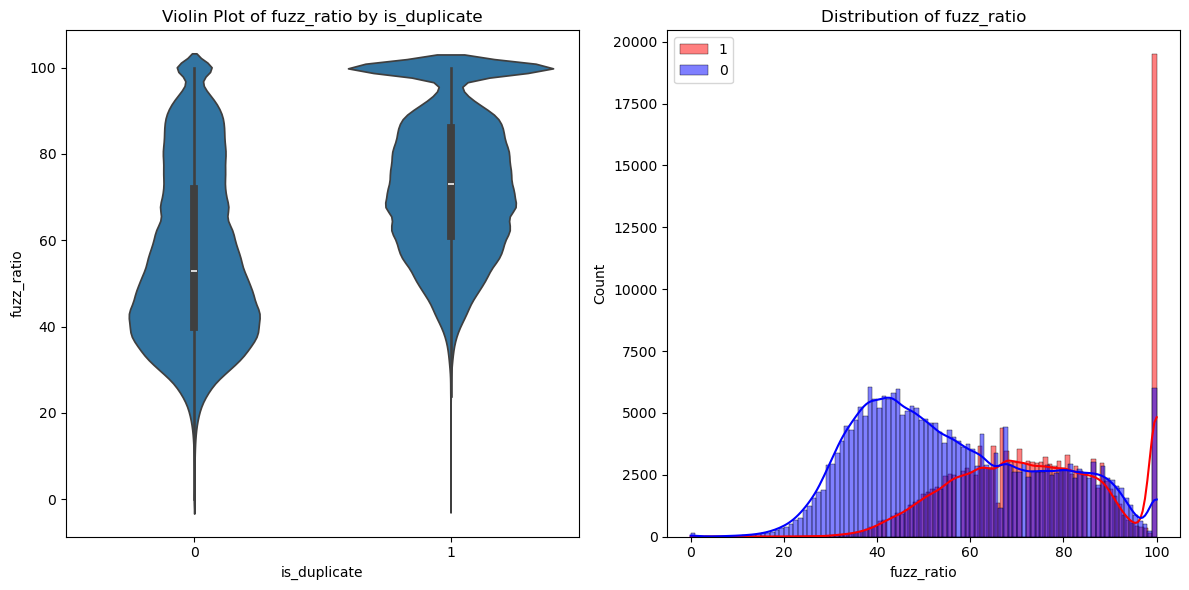

In [64]:
# Distribution of the fuzz_ratio
plt.figure(figsize=(12, 6))

# Subplot 1: Violin plot
plt.subplot(1, 2, 1)
sns.violinplot(x='is_duplicate', y='fuzz_ratio', data=df)
plt.title('Violin Plot of fuzz_ratio by is_duplicate')

# Subplot 2: Histograms
plt.subplot(1, 2, 2)
sns.histplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'], label="1", color='red', kde=True)
sns.histplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'], label="0", color='blue', kde=True)
plt.title('Distribution of fuzz_ratio')
plt.legend()

plt.tight_layout()
plt.show()

## 7)Visualization

In [65]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention


dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.022s...
[t-SNE] Computed neighbors for 5000 samples in 0.337s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.014647
[t-SNE] Computed conditional probabilities in 0.110s
[t-SNE] Iteration 50: error = 84.6566391, gradient norm = 0.0937855 (50 iterations in 0.892s)
[t-SNE] Iteration 100: error = 68.9268799, gradient norm = 0.0153109 (50 iterations in 0.746s)
[t-SNE] Iteration 150: error = 66.2966995, gradient norm = 0.0093211 (50 iterations in 0.673s)
[t-SNE] Iteration 200: error = 65.0993118, gradient norm = 0.0067367 (50 iterations in 0.712s)
[t-SNE] Iteration 250: error = 64.4249496, gradient norm = 0.0059559

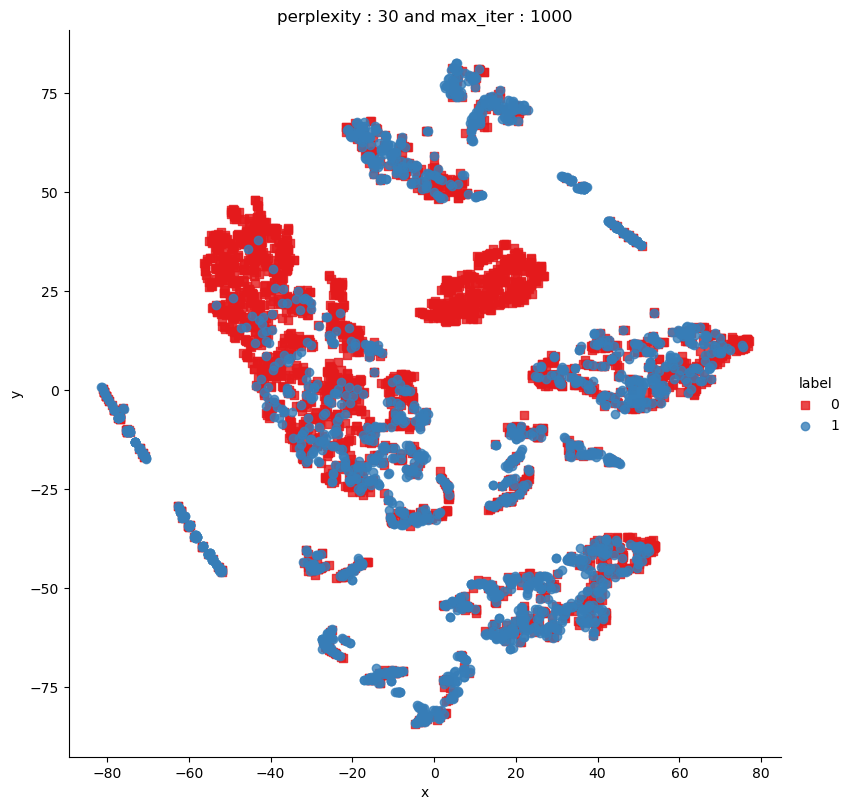

In [66]:
# Create a DataFrame for plotting
df = pd.DataFrame({'x': tsne2d[:,0], 'y': tsne2d[:,1], 'label': y})

# Plot using lmplot with the correct parameters
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, height=8, palette="Set1", markers=['s', 'o'])

plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()


In [67]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.011s...
[t-SNE] Computed neighbors for 5000 samples in 0.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.014647
[t-SNE] Computed conditional probabilities in 0.102s
[t-SNE] Iteration 50: error = 85.3674240, gradient norm = 0.1244905 (50 iterations in 1.540s)
[t-SNE] Iteration 100: error = 67.0138550, gradient norm = 0.0083369 (50 iterations in 1.082s)
[t-SNE] Iteration 150: error = 64.9007645, gradient norm = 0.0042929 (50 iterations in 1.122s)
[t-SNE] Iteration 200: error = 64.0916214, gradient norm = 0.0027897 (50 iterations in 1.198s)
[t-SNE] Iteration 250: error = 63.6295395, gradient norm = 0.0021223

In [68]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.plot(fig, filename='3DBubble')

C:\Users\karti\anaconda3\Lib\site-packages\plotly\offline\offline.py:557: UserWarning:

Your filename `3DBubble` didn't end with .html. Adding .html to the end of your file.



'3DBubble.html'

## 8)Featurizing text data with tfidf weighted word-vectors


In [3]:
df = pd.read_csv("train.csv")

In [4]:
# encode questions to unicode
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [5]:
# merge texts
questions = list(df['question1']) + list(df['question2'])

tfidf = TfidfVectorizer(lowercase= False)
tfidf.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [7]:
nlp = spacy.load('en_core_web_lg')

In [85]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_lg')

vecs1 =[]
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar

for qu1 in tqdm(list(df['question1'])):
  doc1 = nlp(qu1)
  #384 is the number of dimensions of vectors
  mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)]) 
  for word1 in doc1:
    #word2vec
    vec1 = word1.vector
    #fetch df score
    try:
      idf = word2tfidf[str(word1)]
    except:
      idf = 0
    
    # compute final vec
    mean_vec1 += vec1 * idf
  mean_vec1 = mean_vec1.mean(axis= 0)
  vecs1.append(mean_vec1)

df['q1_feats_m'] = list(vecs1)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [36:04<00:00, 186.81it/s]


In [86]:
df2 = df.drop(['qid1','qid2','question1','question2','is_duplicate'], axis=1)
df2_q1 = pd.DataFrame(df2.q1_feats_m.values.tolist(), index= df2.index)
df2_q1.to_csv("q1_feat_train.csv", index= False)

In [8]:
vecs2 = []
for qu2 in tqdm(list(df['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
df['q2_feats_m'] = list(vecs2)

100%|█████████████████████████████████████████████████████████████████████████| 404290/404290 [40:35<00:00, 166.02it/s]


In [9]:
df2 = df.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)
df2_q2 = pd.DataFrame(df2.q2_feats_m.values.tolist(), index= df2.index)
df2_q2.to_csv("q2_feat_train.csv", index= False)

In [3]:
df = pd.read_csv("train.csv")
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df_q1 = pd.read_csv("q1_feat_train.csv")
df_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-17.302041,65.077906,-262.939456,-20.686562,168.056481,37.079087,-62.802002,163.003715,-256.633855,-5.613477,...,120.913699,-132.868682,-111.144140,76.800932,-17.031813,18.101131,-26.370254,-169.293018,-136.936277,95.165242
1,-21.271277,42.341498,84.177521,-106.393414,88.151337,-43.998840,45.112466,109.736580,21.342126,-31.136926,...,51.731451,21.672010,50.035608,-10.191149,-110.361197,60.418664,36.341111,-174.373243,-63.843372,79.621566
2,-48.436742,112.147661,-157.016985,66.946747,200.748916,-25.216032,68.918125,361.157204,-185.235991,79.779303,...,-38.794809,-44.498598,87.357947,27.839210,-68.311364,156.044141,117.030545,-217.245489,-194.690445,63.290935
3,137.433393,79.762091,-111.175812,-172.055902,-100.821880,73.477431,4.726071,176.659988,-144.263077,71.553731,...,134.599823,-151.525408,67.425630,-109.629912,-40.876037,-106.195349,70.469539,85.817208,-158.018648,224.495181
4,8.331834,-108.399996,-214.260982,35.240404,148.534434,-233.111588,-4.039943,342.230251,179.777785,-97.866637,...,69.994948,-110.065816,307.267988,-82.233615,-271.016133,149.470724,368.845373,14.569450,53.777558,-70.254787


In [5]:
df_q2 = pd.read_csv("q2_feat_train.csv")
df_q1.head()

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-17.302041,65.077906,-262.939456,-20.686562,168.056481,37.079087,-62.802002,163.003715,-256.633855,-5.613477,...,120.913699,-132.868682,-111.144140,76.800932,-17.031813,18.101131,-26.370254,-169.293018,-136.936277,95.165242
1,-21.271277,42.341498,84.177521,-106.393414,88.151337,-43.998840,45.112466,109.736580,21.342126,-31.136926,...,51.731451,21.672010,50.035608,-10.191149,-110.361197,60.418664,36.341111,-174.373243,-63.843372,79.621566
2,-48.436742,112.147661,-157.016985,66.946747,200.748916,-25.216032,68.918125,361.157204,-185.235991,79.779303,...,-38.794809,-44.498598,87.357947,27.839210,-68.311364,156.044141,117.030545,-217.245489,-194.690445,63.290935
3,137.433393,79.762091,-111.175812,-172.055902,-100.821880,73.477431,4.726071,176.659988,-144.263077,71.553731,...,134.599823,-151.525408,67.425630,-109.629912,-40.876037,-106.195349,70.469539,85.817208,-158.018648,224.495181
4,8.331834,-108.399996,-214.260982,35.240404,148.534434,-233.111588,-4.039943,342.230251,179.777785,-97.866637,...,69.994948,-110.065816,307.267988,-82.233615,-271.016133,149.470724,368.845373,14.569450,53.777558,-70.254787


In [6]:
df3 = pd.read_csv("train_feat.csv")
df3.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,1,1,66,57,...,0.714276,0.0,1.0,1.0,6.5,100,92,92,100,0.971429
1,1,3,4,stori kohinoor koh noor diamond,would happen indian govern stole kohinoor koh ...,0,4,1,51,88,...,0.399996,0.0,0.0,5.0,7.5,89,62,62,94,0.812500
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dn,0,1,1,73,59,...,0.499992,0.0,0.0,1.0,5.5,85,74,56,64,0.290323
3,3,7,8,mental lone solv,find remaind math 23 24 math divid 24 23,0,1,1,50,65,...,0.000000,0.0,0.0,6.0,6.0,22,21,21,31,0.058824
4,4,9,10,one dissolv water quikli sugar salt methan car...,fish would surviv salt water,0,3,1,76,39,...,0.199998,0.0,0.0,5.0,7.5,53,42,42,54,0.206897


In [7]:
df1 = df.drop(['qid1','qid2','question1','question2'], axis=1)
df3 = df3.drop(['qid1','qid2','question1','question2','is_duplicate'], axis=1)
df3.head()

,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,1,66,57,14,12,10.0,23.0,0.434783,...,0.714276,0.0,1.0,1.0,6.5,100,92,92,100,0.971429
1,1,4,1,51,88,8,13,4.0,20.0,0.200000,...,0.399996,0.0,0.0,5.0,7.5,89,62,62,94,0.812500
2,2,1,1,73,59,14,10,4.0,24.0,0.166667,...,0.499992,0.0,0.0,1.0,5.5,85,74,56,64,0.290323
3,3,1,1,50,65,11,9,0.0,19.0,0.000000,...,0.000000,0.0,0.0,6.0,6.0,22,21,21,31,0.058824
4,4,3,1,76,39,13,7,2.0,20.0,0.100000,...,0.199998,0.0,0.0,5.0,7.5,53,42,42,54,0.206897


In [8]:
print("Number of features in preprocessed dataframe :", df3.shape[1])
print("Number of features in question1 w2v  dataframe :", df_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df_q2.shape[1])
print("Number of features in final dataframe  :", df3.shape[1]+df_q1.shape[1]+df_q2.shape[1])

Number of features in preprocessed dataframe : 27
Number of features in question1 w2v  dataframe : 300
Number of features in question2 w2v  dataframe : 300
Number of features in final dataframe  : 627


In [9]:
df_q1['id'] = df1['id']
df_q2['id'] = df1['id']
df1  = df1.merge(df3, on='id',how='left')
df2  = df_q1.merge(df_q2, on='id',how='left')
result  = df1.merge(df2, on='id',how='left')
result.to_csv('final_feat.csv', index= False)

In [3]:
df = pd.read_csv('final_feat.csv')
df.head()

,id,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,0,0,1,1,66,57,14,12,10.0,23.0,...,89.509871,-110.533625,-100.479424,90.664803,19.507948,-15.140525,-19.345136,-129.408695,-118.284831,89.844395
1,1,0,4,1,51,88,8,13,4.0,20.0,...,81.915579,52.010940,91.056819,-0.052428,-165.972075,103.077540,-83.073252,-68.480301,-117.666431,173.873648
2,2,0,1,1,73,59,14,10,4.0,24.0,...,88.559925,19.308219,128.521377,126.306732,-44.066754,148.308988,152.486339,-244.803431,2.997449,250.107358
3,3,0,1,1,50,65,11,9,0.0,19.0,...,46.109540,-82.958610,25.998560,32.833132,-39.527964,20.387944,-82.090781,-163.982581,34.050951,9.135598
4,4,0,3,1,76,39,13,7,2.0,20.0,...,113.437943,-65.196309,123.960645,-68.888675,-154.013207,-66.353766,8.589358,-33.926499,-25.562273,3.669500


In [5]:
y = df['is_duplicate'][:10000]
X = df[:10000][:]
X.drop(['id','is_duplicate'], axis=1, inplace=True)

## 9) Building ML model

In [6]:
X.head()

,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,...,290_y,291_y,292_y,293_y,294_y,295_y,296_y,297_y,298_y,299_y
0,1,1,66,57,14,12,10.0,23.0,0.434783,2,...,89.509871,-110.533625,-100.479424,90.664803,19.507948,-15.140525,-19.345136,-129.408695,-118.284831,89.844395
1,4,1,51,88,8,13,4.0,20.0,0.200000,5,...,81.915579,52.010940,91.056819,-0.052428,-165.972075,103.077540,-83.073252,-68.480301,-117.666431,173.873648
2,1,1,73,59,14,10,4.0,24.0,0.166667,2,...,88.559925,19.308219,128.521377,126.306732,-44.066754,148.308988,152.486339,-244.803431,2.997449,250.107358
3,1,1,50,65,11,9,0.0,19.0,0.000000,2,...,46.109540,-82.958610,25.998560,32.833132,-39.527964,20.387944,-82.090781,-163.982581,34.050951,9.135598
4,3,1,76,39,13,7,2.0,20.0,0.100000,4,...,113.437943,-65.196309,123.960645,-68.888675,-154.013207,-66.353766,8.589358,-33.926499,-25.562273,3.669500


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify= y, test_size=0.3)

In [9]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (7000, 626)
Number of data points in test data : (3000, 626)


In [14]:
print("Distribution of output variable in train data")
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print(50*"-")
print("Distribution of output variable in train data")
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

Distribution of output variable in train data
Class 0:  0.6288571428571429 Class 1:  0.37114285714285716
--------------------------------------------------
Distribution of output variable in train data
Class 0:  0.371 Class 1:  0.371


In [16]:
# This function plots the confusion matrices given y_i, y_i_hat.

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

### Building a random model (Finding worst-case log-loss)

Log loss on Test Data using Random Model 0.872620144875518


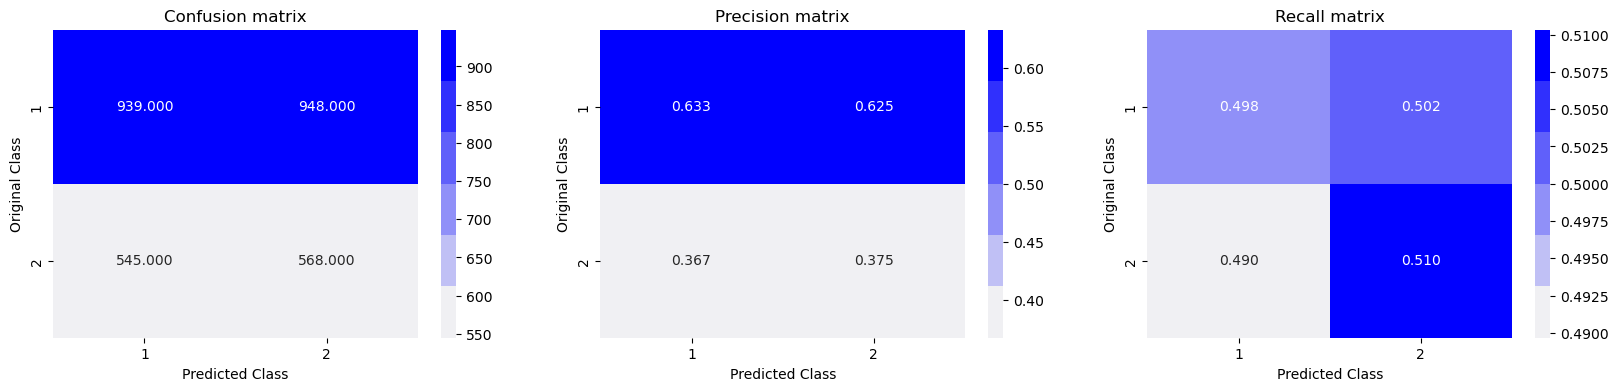

In [23]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data

predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

### Logistic Regression with hyperparameter tuning

For alpha = 0.000010, log loss: 0.552047
For alpha = 0.000100, log loss: 0.552445
For alpha = 0.001000, log loss: 0.544747
For alpha = 0.010000, log loss: 0.547033
For alpha = 0.100000, log loss: 0.552322
For alpha = 1.000000, log loss: 0.546340
For alpha = 10.000000, log loss: 0.552786


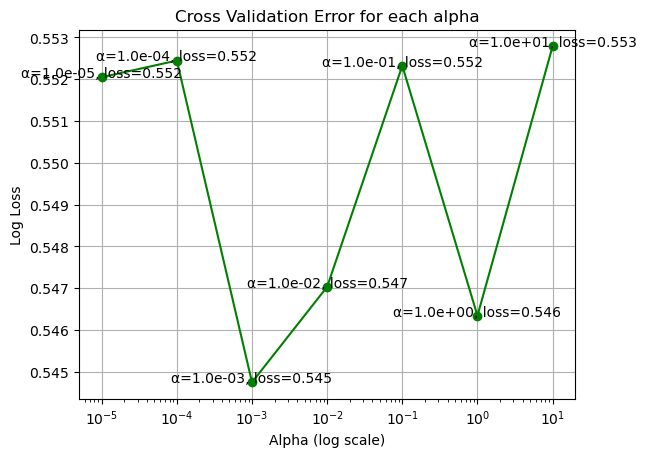

Best alpha = 0.001000, Train log loss: 0.509991
Best alpha = 0.001000, Test log loss: 0.544747
Total number of data points: 3000


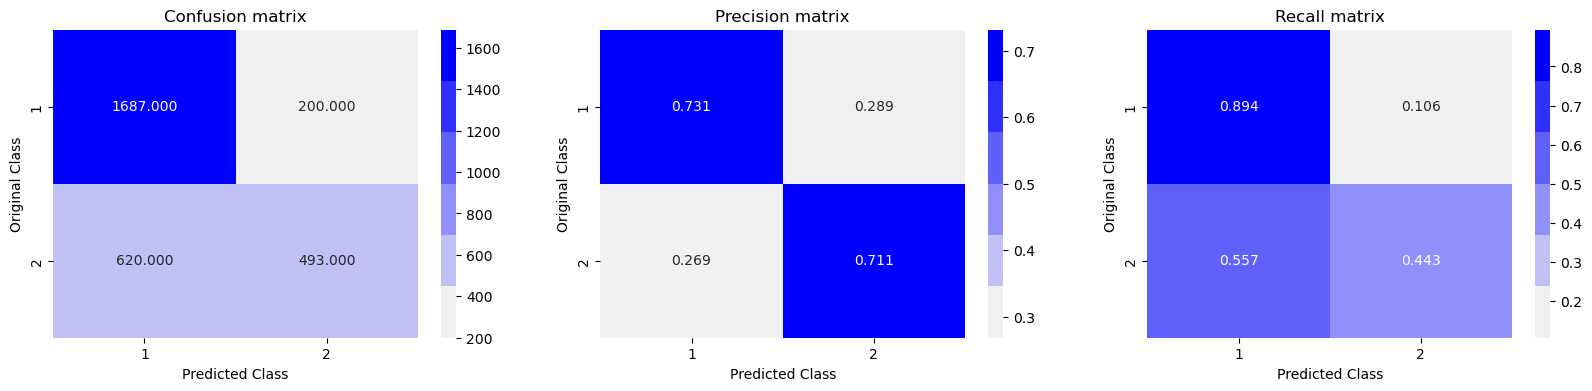

In [26]:
# Set of hyperparameters (alpha values) for the SGD classifier
alpha = [10 ** x for x in range(-5, 2)]

# List to store the log loss for each alpha
log_error_array = []

# Loop through each alpha and calculate log loss
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log_loss', random_state=42)
    clf.fit(X_train, y_train)
    
    # Calibrate the classifier with sigmoid method
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    predict_y = sig_clf.predict_proba(X_test)
    
    # Calculate log loss and append it to the log_error_array
    log_loss_value = log_loss(y_test, predict_y, labels=clf.classes_)
    log_error_array.append(log_loss_value)
    
    # Print log loss for each alpha
    print(f'For alpha = {i:.6f}, log loss: {log_loss_value:.6f}')

# Plotting the log loss values for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g', marker='o')

# Annotate points on the graph
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.text(alpha[i], log_error_array[i], f'α={alpha[i]:.1e}, loss={txt}', ha='center')

# Set labels and title for the plot
plt.grid(True)
plt.xscale('log')  # Since alpha is on a logarithmic scale
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Log Loss")
plt.show()


# Find the best alpha (the one with the lowest log loss)
best_alpha_idx = np.argmin(log_error_array)
best_alpha = alpha[best_alpha_idx]

# Train a classifier with the best alpha
clf = SGDClassifier(alpha=best_alpha, penalty='l2', loss='log_loss', random_state=42)
clf.fit(X_train, y_train)

# Calibrate and fit the classifier
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

# Evaluate on the training set
predict_y_train = sig_clf.predict_proba(X_train)
train_log_loss = log_loss(y_train, predict_y_train, labels=clf.classes_)
print(f'Best alpha = {best_alpha:.6f}, Train log loss: {train_log_loss:.6f}')

# Evaluate on the test set
predict_y_test = sig_clf.predict_proba(X_test)
test_log_loss = log_loss(y_test, predict_y_test, labels=clf.classes_)
print(f'Best alpha = {best_alpha:.6f}, Test log loss: {test_log_loss:.6f}')

# Find the predicted class labels
predicted_y = np.argmax(predict_y_test, axis=1)
print("Total number of data points:", len(predicted_y))

# Plot the confusion matrix
plot_confusion_matrix(y_test, predicted_y)

### Linear SVM with hyperparameter tuning

For alpha = 0.000010, log loss: 0.581350
For alpha = 0.000100, log loss: 0.587609
For alpha = 0.001000, log loss: 0.591390
For alpha = 0.010000, log loss: 0.602519
For alpha = 0.100000, log loss: 0.620885
For alpha = 1.000000, log loss: 0.655038
For alpha = 10.000000, log loss: 0.648124


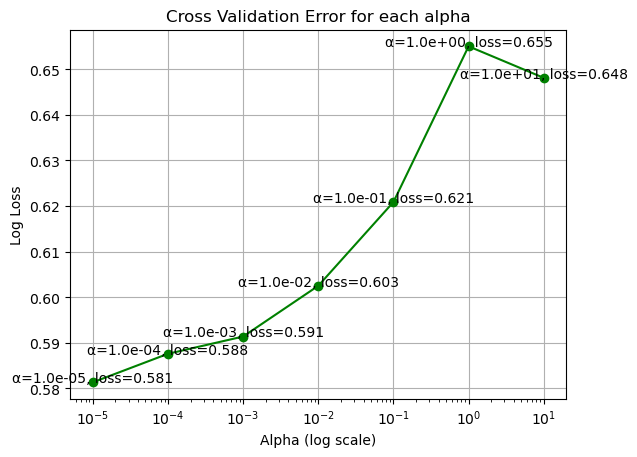

Best alpha = 0.000010, Train log loss: 0.487033
Best alpha = 0.000010, Test log loss: 0.527344
Total number of data points: 3000


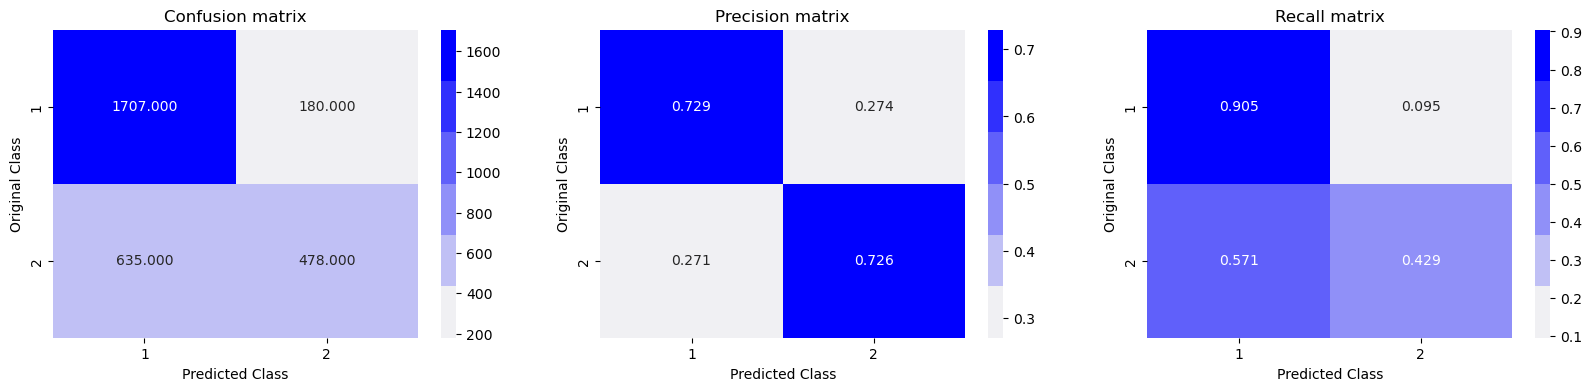

In [31]:
# Set of hyperparameters (alpha values) for the SGD classifier
alpha = [10 ** x for x in range(-5, 2)]

# List to store the log loss for each alpha
log_error_array = []

max_iter_value = 10000  # Increase further
learning_rate_value = 0.001  # Lower learning rate
tolerance = 1e-5  # Lower tolerance

# Loop through each alpha and calculate log loss
for i in alpha:
    # Create an SGDClassifier with L1 regularization and hinge loss (for SVM)
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42, 
                    max_iter=20000, tol=1e-5, eta0=0.001, early_stopping=True, n_iter_no_change=5)
    clf.fit(X_train, y_train)
    
    # Calibrate the classifier with sigmoid method
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    
    # Predict probabilities on the test set
    predict_y = sig_clf.predict_proba(X_test)
    
    # Calculate log loss and append it to the log_error_array
    log_loss_value = log_loss(y_test, predict_y, labels=clf.classes_)
    log_error_array.append(log_loss_value)
    
    # Print log loss for each alpha
    print(f'For alpha = {i:.6f}, log loss: {log_loss_value:.6f}')


# Plotting the log loss values for each alpha
fig, ax = plt.subplots()
ax.plot(alpha, log_error_array, c='g', marker='o')

# Annotate points on the graph
for i, txt in enumerate(np.round(log_error_array, 3)):
    ax.text(alpha[i], log_error_array[i], f'α={alpha[i]:.1e}, loss={txt}', ha='center')

# Set labels and title for the plot
plt.grid(True)
plt.xscale('log')  # Since alpha is on a logarithmic scale
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Log Loss")
plt.show()

# Find the best alpha (the one with the lowest log loss)
best_alpha_idx = np.argmin(log_error_array)
best_alpha = alpha[best_alpha_idx]

# Train a classifier with the best alpha
clf = SGDClassifier(alpha=best_alpha, penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)

# Calibrate and fit the classifier
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

# Evaluate on the training set
predict_y_train = sig_clf.predict_proba(X_train)
train_log_loss = log_loss(y_train, predict_y_train, labels=clf.classes_)
print(f'Best alpha = {best_alpha:.6f}, Train log loss: {train_log_loss:.6f}')

# Evaluate on the test set
predict_y_test = sig_clf.predict_proba(X_test)
test_log_loss = log_loss(y_test, predict_y_test, labels=clf.classes_)
print(f'Best alpha = {best_alpha:.6f}, Test log loss: {test_log_loss:.6f}')

# Find the predicted class labels
predicted_y = np.argmax(predict_y_test, axis=1)
print("Total number of data points:", len(predicted_y))

# Plot the confusion matrix (assuming the function is defined elsewhere)
plot_confusion_matrix(y_test, predicted_y)

### XGBoost


In [38]:
# Initialize the XGBClassifier (no need for `use_label_encoder` anymore)
xgb_clf = XGBClassifier(
    learning_rate=0.02, 
    max_depth=4, 
    objective='binary:logistic', 
    eval_metric='logloss', 
    n_estimators=400,
    tree_method='hist',  # Use GPU-based tree building
    device='cuda'        # Set to GPU for CUDA-based computation
)
print("-----")

# Define hyperparameter grid for tuning
param_grid = {
    'learning_rate': [0.01, 0.02, 0.05],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 400],
    'colsample_bytree': [0.7, 0.8, 1.0]
}
print("-----")

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, scoring='neg_log_loss', cv=5, verbose=1)
print("-----")

# Fit the model (tuning hyperparameters)
grid_search.fit(X_train, y_train)
print("-----")

# Get the best estimator and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print("-----")

# Predict probabilities for the test set
predict_y = best_model.predict_proba(X_test)[:, 1]

# Log loss evaluation
print("The test log loss is:", log_loss(y_test, predict_y))

-----
-----
-----
Fitting 5 folds for each of 81 candidates, totalling 405 fits
-----
-----
The test log loss is: 0.3725041565782726


Total number of data points : 3000


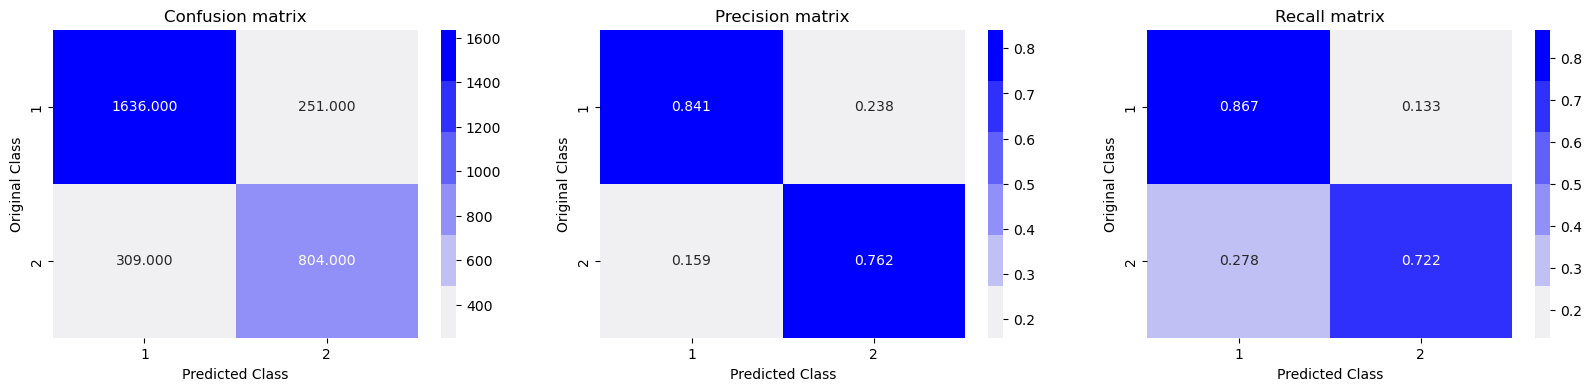

In [39]:
# Convert probabilities to binary predictions using a 0.5 threshold
predicted_y = np.array(predict_y > 0.5, dtype=int)

# Output the total number of data points predicted
print("Total number of data points :", len(predicted_y))

# Plot the confusion matrix between true labels and predicted labels
plot_confusion_matrix(y_test, predicted_y)

In [43]:
# Initialize PrettyTable
table = PrettyTable()

# Add column names
table.field_names = ["Model", "Test Log Loss"]

# Add rows
table.add_row(["Random", 0.872620])
table.add_row(["Logistic Regression", 0.544747])
table.add_row(["Linear SVM", 0.527344])
table.add_row(["XGBoost", 0.372504])

# Display the table
print(table)

+---------------------+---------------+
|        Model        | Test Log Loss |
+---------------------+---------------+
|        Random       |    0.87262    |
| Logistic Regression |    0.544747   |
|      Linear SVM     |    0.527344   |
|       XGBoost       |    0.372504   |
+---------------------+---------------+
